In [1]:
%matplotlib inline
import numpy as np
import os, glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import timeit
from pandas import to_datetime, date_range
import wrf, xarray

In [2]:
plt.rc("font",size=14)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### define paths

In [4]:
dataPath = '/glade/scratch/domingom/Cheyenne/XPIA_mesoLES/SIMULS/'
outPath  = '/glade/scratch/doubrawa/postProcessing/'

### define some parameters

In [5]:
n_processors       = 1800
domainId           = 3
prefix             = "LES_25m" if domainId==4 else "LES_100m"

In [6]:
nt_per_file        = 180 if domainId==4 else 30
nhours             = 10
nfiles             = nhours * 2
nt_total           = nt_per_file * nfiles

n_east_west        = 1200
n_east_west_stag   = n_east_west + 1
n_south_north      = 1200
n_south_north_stag = n_south_north + 1

### reference wrf to clip domains

In [7]:
ref_wrfnc = Dataset("/glade/scratch/domingom/Cheyenne/XPIA_mesoLES/SIMULS/WRF_mesoLES_4dom_RAP_2015_03_12_mesoLES/HOUR_14_1/wrfout_d04_2015-03-13_14:00:10_0000")

## open all data

In [11]:
year           = 2018
month          = 3
day            = 21
hour           = 23
minute         = 30
half_hour_idx  = 1 if minute<30 else 2
datetime       = to_datetime("{0}-{1}-{2} {3}:{4}".format(year,month,day,hour,minute),format="%Y-%m-%d %H:%M")
print(datetime)

2018-03-21 23:30:00


In [12]:
variables_2d = ["XLAT","XLONG","ter","RMOL","HFX"]
variables_3d = ["U","V","wa","theta","z"]
variables    = variables_2d + variables_3d
data         = {}
for var in ["U"]:
    data[var] = np.zeros((72,n_south_north,n_east_west_stag))
for var in ["V"]:
    data[var] = np.zeros((72,n_south_north_stag,n_east_west))    
for var in variables_2d:
    data[var] = np.zeros((1200,1200))
for var in ["wa","theta","z"]:
    data[var] = np.zeros((72,n_south_north,n_east_west))        

In [13]:
for processor in range(n_processors):

    wrfoutPath     = (glob.glob(os.path.join(dataPath,
                               'WRF_mesoLES_4dom_RAP_2015_03_{0}_mesoLES'.format(day-1),
                               'HOUR_{0}_{1}'.format(hour,half_hour_idx),
                               'wrfout_d0{0}_*_{1:04d}'.format(domainId,processor))))[0]
    print (os.path.split(wrfoutPath)[-1])
    wrfnc = xarray.open_dataset(wrfoutPath)
    wrfnc_for_wrf = Dataset(wrfoutPath,'r')
    wrf_datetime = to_datetime(wrfnc.XTIME[0].data)


    if ((wrf_datetime-datetime).seconds > 5 * 60.0):
        print ("ERROR!!!")   
    
    #
    # get all variables (3-d in space) 
    #
    for var in variables:

        try:
            data_tmp = wrf.getvar(wrfnc_for_wrf, var, timeidx=0).data
        except:
            data_tmp = wrfnc[var].isel(Time=0).data       
            
        we_0 = getattr(wrfnc,'WEST-EAST_PATCH_START_UNSTAG') - 1        
        we_1 = getattr(wrfnc,'WEST-EAST_PATCH_END_UNSTAG')                

        sn_0 = getattr(wrfnc,'SOUTH-NORTH_PATCH_START_UNSTAG') - 1       
        sn_1 = getattr(wrfnc,'SOUTH-NORTH_PATCH_END_UNSTAG')               
            
            
            
        if data_tmp.ndim==3:
            if var=='U':
                we_0 = getattr(wrfnc,'WEST-EAST_PATCH_START_STAG') - 1        
                we_1 = getattr(wrfnc,'WEST-EAST_PATCH_END_STAG')                                
            if var=='V':
                sn_0 = getattr(wrfnc,'SOUTH-NORTH_PATCH_START_STAG') - 1       
                sn_1 = getattr(wrfnc,'SOUTH-NORTH_PATCH_END_STAG')                                                                       
            data[var][:, sn_0:sn_1, we_0:we_1] = data_tmp.copy()
        else:
            data[var][sn_0:sn_1, we_0:we_1] = data_tmp.copy()           
            
    break

wrfout_d03_2015-03-21_23:31:00_0000


In [17]:
                wrf_datetimes  = np.asarray([ to_datetime(ii) for ii in wrfnc.XTIME.data ])


In [26]:
data["HFX"].shape

(1200, 1200)

In [53]:
data["z"] = data["z"] - data["ter"]

# unstagger u and v

In [54]:
data["U"] = 0.5*(data["U"][:,:,0:n_east_west_stag-1] + data["U"][:,:,1:n_east_west_stag+1])

In [55]:
data["V"] = 0.5*(data["V"][:,0:n_south_north_stag-1,:] + data["V"][:,1:n_south_north_stag+1,:])

# clip

In [56]:
x,y = wrf.ll_to_xy(ref_wrfnc, data["XLAT"], data["XLONG"])    

x   = np.reshape(x.data,data["wa"].shape[1:])
y   = np.reshape(y.data,data["wa"].shape[1:])    

idx_j, idx_i = np.where ( (x>=0) & (y>=0) & (x<=1200) & (y<=1200) )

j0, j1 = np.min(idx_j), np.max(idx_j)
i0, i1 = np.min(idx_i), np.max(idx_i)

data2 = {}
for var in data:
    print (var)
    ndim = (len(data[var].shape))
    if ndim==3:
        data2[var] = data[var][:,j0:j1+1,i0:i1+1].copy()
    if ndim==2:
        data2[var] = data[var][j0:j1+1,i0:i1+1].copy()        

data = data2

# get x,y mean

In [62]:
data_mean = {}
for var in ["U","V","wa","theta","z"]:
    data_mean[var] = np.mean(data[var],axis=(1,2))

# get x,y perturbations

In [63]:
data_prime  = {}
for var in data_mean.keys():
    print (var)
    data_prime[var] = data[var] - data_mean[var][:,None,None]   

U
V
wa
theta
z


# compute fluxes

In [64]:
fluxes = ["U_U","V_V","wa_wa","U_wa","V_wa","U_V","wa_theta"]
data_fluxes = {}
for flux in fluxes:
    var1 = flux.split("_")[0]
    var2 = flux.split("_")[1]
    data_fluxes[flux] = np.mean(data_prime[var1]*data_prime[var2],axis=(1,2))

In [65]:
data_fluxes["wa_theta0"] = np.mean(data_prime["wa"]*data_prime["theta"][0,:,:],axis=(1,2))

# take a peek

In [66]:
z_profile = data_mean["z"].copy()

In [67]:
wth_profile = data_fluxes["wa_theta"].copy()

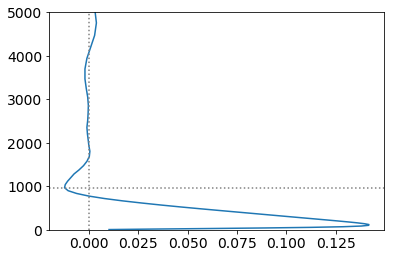

In [68]:
fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)

idx = np.where(z_profile<5000)[0]
idx_zi = np.argmin(wth_profile[idx])
zi = z_profile[idx_zi]

ax.plot(wth_profile,z_profile)
ax.set_ylim([0,5000])
ax.axhline(y=zi,color='gray',linestyle=":")
ax.axvline(x=0,color='gray',linestyle=":")

# save

In [69]:
import pandas as pd

In [70]:
df = pd.DataFrame(data_mean).set_index("z")

In [71]:
df["z_std_xy"] = np.std(data["z"],axis=(1,2))

In [72]:
df2 = pd.DataFrame(data_fluxes).set_index(df.index)

In [73]:
df = pd.concat([df,df2],axis=1)

In [74]:
column_mapping = {"U":"u",
 "V":"v",
 "wa":"w",
 "theta":"theta",
 "z_std_xy":"z_std_xy",
 "U_U":"u_u",
 "V_V":"v_v",
 "wa_wa":"w_w",
 "U_wa":"u_w",
 "V_wa":"v_w",
 "U_V":"u_v",
 "wa_theta":"w_theta",
 "wa_theta0":"w_theta0"}

In [75]:
df.columns = [ column_mapping[col_old] for col_old in df.columns ]

In [76]:
df.head()

,u,v,w,theta,z_std_xy,u_u,v_v,w_w,u_w,v_w,u_v,w_theta,w_theta0
z,,,,,,,,,,,,,
5.590016,-0.324822,1.319098,-0.002386,304.318147,0.015823,1.144894,0.896708,0.002359,-0.005205,-0.008945,-0.032079,0.010142,0.010142
17.111373,-0.382490,1.592291,-0.003434,304.098439,0.048289,1.463748,1.086908,0.017274,-0.008020,-0.024381,-0.037726,0.033451,0.030778
29.346593,-0.413468,1.818832,-0.004578,303.912599,0.082608,1.638690,1.159673,0.049552,-0.012080,-0.041868,-0.041584,0.061112,0.052587
42.351014,-0.425649,2.001396,-0.005779,303.762330,0.119091,1.707916,1.152279,0.099631,-0.018004,-0.057810,-0.043095,0.089087,0.074252
56.174093,-0.425611,2.147187,-0.007002,303.647687,0.157908,1.709763,1.102389,0.164843,-0.025627,-0.070827,-0.042359,0.112523,0.094428


In [77]:
fName = os.path.join(outPath,"WRF_LES_100m_CLIPPED_SPATIAL_AVERAGED_PROFILES_{0:%Y-%m-%d_%H:%M:%S}.csv".format(datetime))
print(fName)

df.to_csv(fName)

/glade/scratch/doubrawa/postProcessing/WRF_LES_100m_CLIPPED_SPATIAL_AVERAGED_PROFILES_2018-03-21_18:30:00.csv
